In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio
import matplotlib.cm as cm
from matplotlib import animation



Import the usual suspects

In [3]:
PITCH = 4.2
alpha = 10
beta_0 = 1.3182817e+7
coupling = 191

## Building and solving a coupling matrix

We want to solve something of the form 

$i \frac{\partial \phi_n}{\partial z} = C_{m, m+a_1} e^{iA((m + a_1) /2)\cdot a_1} \phi_{m+a_1} +  C_{m, m+a_2} e^{iA((m + a_2) /2)\cdot a_2} \phi_{m+a_2}+  C_{m, m+a_3} e^{iA((m + a_3) /2)\cdot a_3} \phi_{m+a_3} + D_n \phi_n $

The first three terms are the effects due to coupling with neighbours, while the fourth term is the on-site change due to the presence of twist.

First let's define a function that handles the effects of twist

Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$


In [4]:
def twisted_beta(beta_straight, twist_rate, radial_dist):
    beta_hel = beta_straight*np.sqrt(1+ twist_rate**2 * radial_dist**2)
    # print('Difference due to twist: {:.2f}'.format(beta_hel-beta_straight))
    return beta_hel

vec_twist_beta = np.vectorize(twisted_beta)

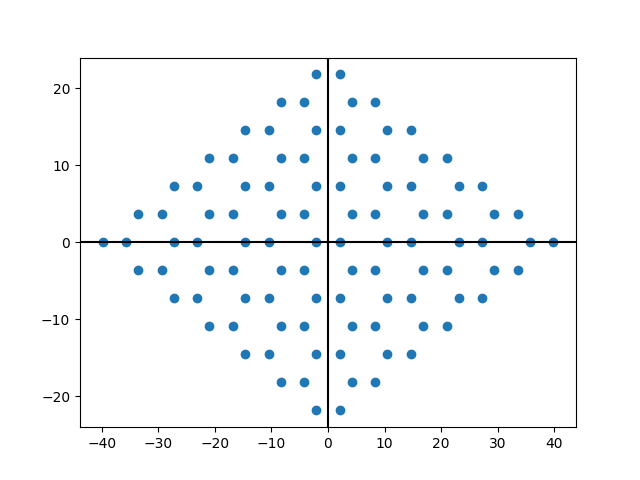

98


In [5]:
def build_honeycomb(n,m, pitch):
    a_1 = np.array([3*pitch/2, np.sqrt(3)*pitch/2])
    a_2 = np.array([3*pitch/2, -np.sqrt(3)*pitch/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-pitch, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)
    centered_coord_list = full_coord_list - (n*a_1 + m*a_2)/2 + np.array([2*pitch,0])

    return centered_coord_list
b_10_list = build_honeycomb(7, 7, PITCH)

plt.axhline(0, color='black')
plt.axvline(0, color='black')



plt.scatter(b_10_list[:,0], b_10_list[:,1]); 
plt.show()
print(len(b_10_list))

If we want a deformed lattice we can delete cores using the code below 

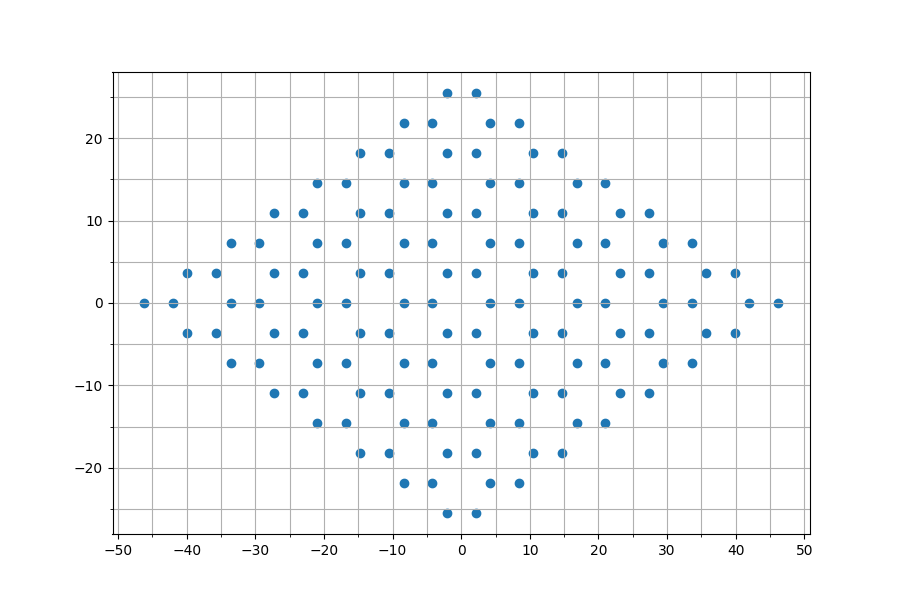

In [22]:
def onclick(event):
    pos.append([event.xdata,event.ydata])

pos = []

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

ax1.scatter(b_10_list[:,0], b_10_list[:,1], cmap='Reds')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig1.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [23]:

pos = np.array(pos)
points_to_keep = np.where(cdist(b_10_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
# deformed_lattice_zig= b_10_list[index_to_keep]
deformed_lattice= b_10_list[index_to_keep]
# [print(type(i)) for i in pos]
# print(pos)

ValueError: XB must be a 2-dimensional array.

NameError: name 'deformed_lattice' is not defined

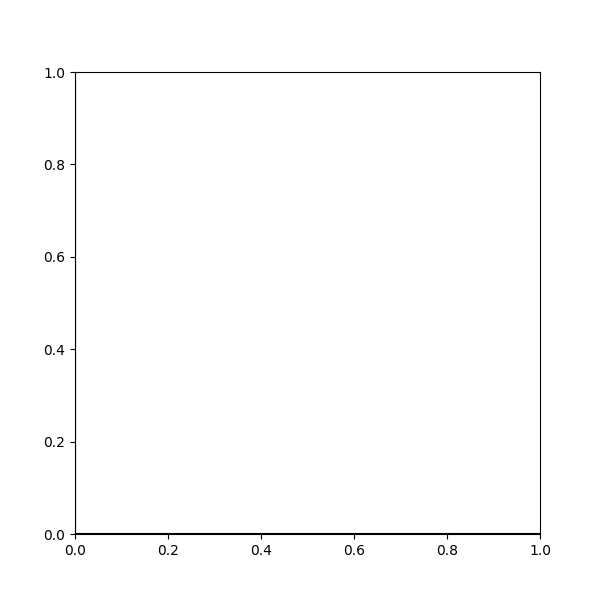

In [ ]:
fig_deformed_lattice_plot = plt.figure(figsize=(6,6))
ax_deformed_lattice_plot = fig_deformed_lattice_plot.add_subplot(111)
ax_deformed_lattice_plot.axhline(0, color='black')
ax_deformed_lattice_plot.axvline(0, color='black')
ax_deformed_lattice_plot.scatter(deformed_lattice[:,0], deformed_lattice[:,1])
ax_deformed_lattice_plot.set_aspect('equal')
for i in range(len(deformed_lattice)):
    # print(i, coord)
    ax_deformed_lattice_plot.annotate(str(i), (deformed_lattice[i,0], deformed_lattice[i,1]), fontsize=8)
print(len(deformed_lattice))

plt.show()

Now we want to read in a geometry from COMSOL and find the nearest neighbours

In [26]:

# coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/honeycomb coord locs small.csv', header=4,float_precision='round_trip')
# # coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/coupled_core_locs.csv', header=4,float_precision='round_trip')

# #display(coord_data.iloc[:,1:])
# x_coords = coord_data.iloc[:,1:128]
# y_coords = coord_data.iloc[:,128:]
# x_coord_np = x_coords.transpose()[0].to_numpy()
# y_coord_np = y_coords.transpose()[0].to_numpy()

# combined_list  = np.transpose(np.array((x_coord_np,y_coord_np)))


def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

Next we build up the vector potential $\mathbf{A}(\mathbf{r})$

In [27]:
def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A


Finally we stick all of these components into our coupling matrix C

In [28]:
def find_eigvalues(pair_list, pitch, coupling_c, beta_straight, twist, with_onsite=True):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    if with_onsite is True:
        onsite_matrix = build_onsite(beta_straight, twist, pair_list)
        full_C = coupling_matrix + onsite_matrix
    else: 
        full_C = coupling_matrix
    # print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    beta_super, eigvecs = np.linalg.eigh(full_C)

    return beta_super,eigvecs


In [29]:
# Plotting betas
def plot_betas(beta_vals, coupling, point_label, xrange=[]):
    fig1  = plt.figure(figsize=(9,9))   
    ax1 = fig1.add_subplot(111)
    if type(beta_vals) == list:
        for i,vals in enumerate(beta_vals):
            ax1.scatter(np.arange(len(vals)), vals, label=point_label[i])

    else: 
        ax1.scatter(np.arange(len(beta_vals)), beta_vals-np.mean(beta_vals), label=point_label)
    ax1.grid(axis='x', which='both')
    ax1.set_ylabel(r'$ \beta$')
    ax1.set_xlabel('Mode Index')
    if len(xrange) == 2:
        ax1.set_xlim(xrange[0],xrange[1])
    plt.legend();
    # fig1.savefig('../Twisted Fibre/Figures/twisted_fibre_betas_with_onsite.svg', dpi=300)


In [30]:
# For nice plotting of eigenvectors 

def plot_coloured_chain(intensities, circ_size, circ_locations, label ):
    """
    
    """
    fig_chain = plt.figure(figsize=(10,8))
    ax_chain = fig_chain.add_subplot(111)
    # intensities = intensities/np.sum(intensities)
    circ_list = []
    if np.any(intensities < 0):
        norm = colors.TwoSlopeNorm(0, vmin=min(np.real(intensities)), vmax=max(np.real(intensities)))
        cmap= plt.cm.get_cmap('seismic')
    else:
        norm = colors.Normalize(vmin=0, vmax=max(np.real(intensities)))#TwoSlopeNorm(0, vmin=min(np.real(intensities)), vmax=max(np.real(intensities)))
        cmap = plt.cm.get_cmap('gist_gray_r')
    # cmap(norm(np.real(intensities)))

    for j in range(len(intensities)):
        #print(intensities[j])
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color=cmap(norm(np.real(intensities[j]))),ec='black')) 
        if np.real(intensities[j]) > 0:
            ax_chain.annotate('+',(circ_locations[j][0], circ_locations[j][1]), color='black',
                          fontsize=10, ha='center', va='center')
        elif np.real(intensities[j]) < 0: 
            ax_chain.annotate('-',(circ_locations[j][0], circ_locations[j][1]), color='black',
                          fontsize=10, ha='center', va='center')
        ax_chain.annotate(str(j), (circ_locations[j][0]+1, circ_locations[j][1]+1), color='black',
                          fontsize=10)#, ha='center', va='center')
   
    # plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.title('Mode no. {:d}'.format(label), loc='left')
    plt.axis('scaled')
    cmappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax_chain)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(cmappable, cax=cax)
    plt.show()     
    return  



In [31]:
def find_eigvalues_haldane(pair_list, pitch, coupling_c1, coupling_c2, M):
    """  
        pair_lisst is the lattice coord list, pitch is the distance between nearest neighbours,
        coupling_c1 is nn coupling, coupling_c2 is nnn coupling, M is the onsite term.

        First I build a tree and find all nearest and next-nearest neighbours, splitting them 
        into separate lists to build up the coupling matrix with. 

        The angle between points (when nnn) is calculated to determine the sign of the imaginary 
        coupling. This gives the points a positive imaginary coupling if they're travelling 
        anticlockwise and negative if clockwise.
    """
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=np.complex128)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=50)
    next_and_neighbour_array = honeycomb_point_tree.query_pairs(np.sqrt(3)*(pitch+0.001), output_type = 'ndarray')
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.0001, output_type = 'ndarray')
    
    # easiest to create a list of tuples to remove any nearest neighbours from all pairs
    #  within next-nearest neighbour distance
    tup_all_list = [(i[0],i[1]) for i in next_and_neighbour_array]
    tup_nn_list = [(i[0],i[1]) for i in nearest_neighbour_array]
    tup_next_n_list = [i for i in tup_all_list if i not in tup_nn_list]

    for n in nearest_neighbour_array:
        coupling_matrix[n[0],n[1]] = coupling_c1
        coupling_matrix[n[1],n[0]] = coupling_c1

    # Logic to build up clockwise dependent phase in next-nearest neighbour coupling
    for i in tup_next_n_list:
        if i[0] >= len(pair_list)//2:
            a_or_b = -1
        else:
            a_or_b = 1
        # print(a_or_b)
        vec_between_points = pair_list[i[1]] - pair_list[i[0]]
        if vec_between_points[0] == 0:
            if vec_between_points[1] > 0:
                coupling_i = 1.0j*coupling_c2  
            elif vec_between_points[1] < 0: 
                coupling_i = -1.0j*coupling_c2 
        else:
            angle_between_points = np.arctan(vec_between_points[1]/vec_between_points[0])
            if angle_between_points > 0 and angle_between_points < 4*np.pi/10:
                coupling_i = -1.0j*coupling_c2 
            elif angle_between_points < 0 and angle_between_points > -4*np.pi/10: 
                coupling_i = 1.0j*coupling_c2 

        coupling_matrix[i[0],i[1]] = a_or_b*coupling_i
        coupling_matrix[i[1],i[0]] = -a_or_b*coupling_i       

    a_size = int(len(pair_list[:,0])/2)
    onsite = np.block([[np.eye(a_size),np.zeros((a_size, a_size))],
                       [np.zeros((a_size, a_size)),np.eye(a_size)*-1]])*M 
    # onsite = np.eye(len(pair_list[:,0]),dtype=np.complex128)*M 
    full_matrix = coupling_matrix + onsite
    if np.allclose(full_matrix,np.transpose(np.conjugate(full_matrix))) is True:
        print('Hermitian')
    # display(pd.DataFrame(full_matrix))
    beta_super, eigvecs = np.linalg.eigh(full_matrix)

    return beta_super,eigvecs

In [39]:
beta_vals_zig, beta_vecs_zig = find_eigvalues(b_10_list, 4.2, 6700.0, 5876619.5, 2000, with_onsite=False)
# beta_vals_arm, beta_vecs_arm = find_eigvalues(deformed_lattice_arm, 4.2, 6700, 5876619.5, 1000, with_onsite=False)
beta_vals_hald, beta_vecs_hald = find_eigvalues_haldane(b_10_list, 4.2, 1.0, 0.26, 0.00)

Hermitian


We now have $i \frac{\partial \mathbf{a}}{\partial z} = C \mathbf{a}$ 
where $\mathbf{a}$ is a vector of complex amplitudes describing the contribution of each single core mode to each supermode k

$\beta \mathbf{a} = C \mathbf{a}$

[ 64  63  72  62  65  55 112  70  57  15  31  59  96  68  58  23  69 104]
[  7 120  71  56  15 112  70  57  58  23 104  69  64  63  59  31  96  68]
[  0 127   1   8 126 119  16   2 111 125 103   3  24 124   9 118  95  32]
[120  71  56   7  57 112  15  70  58  23 104  69  64  63  59  31  96  68]
[ 64  63  62  55  65  72  57 112  70  15  31  59  68  96  58  23 104  69]


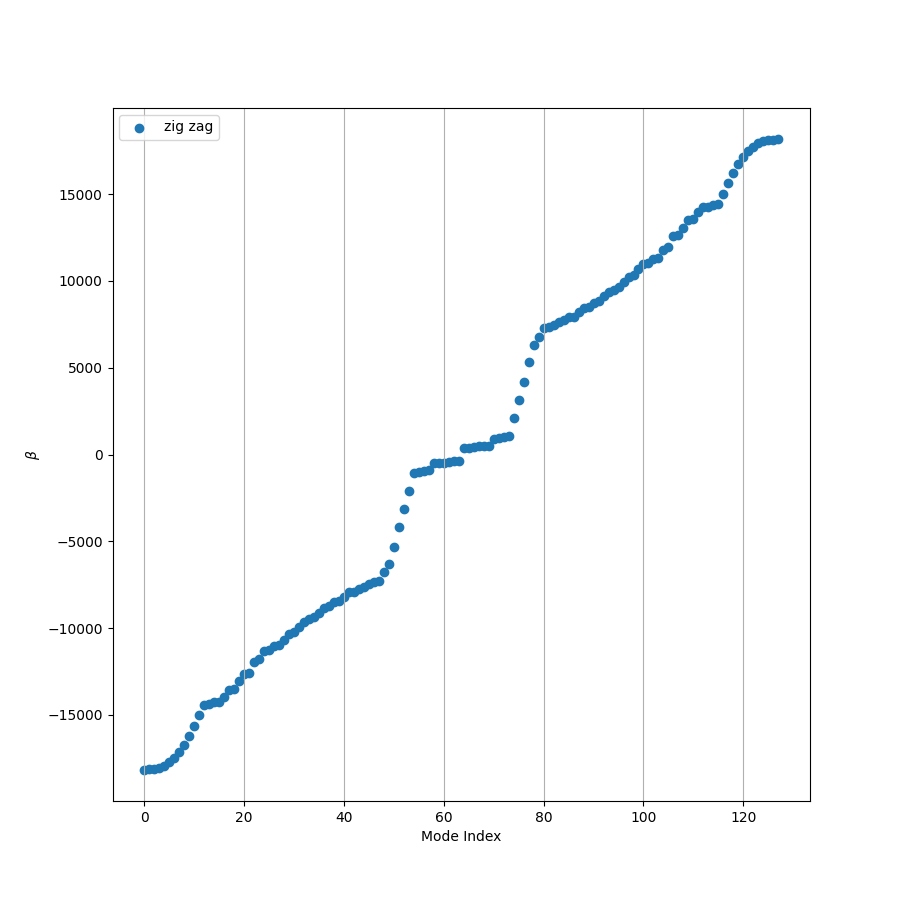

In [41]:
plot_betas(beta_vals_zig,0,'zig zag')
intensities_plot = beta_vecs_zig*np.conjugate(beta_vecs_zig)/ np.sum(beta_vecs_zig*np.conjugate(beta_vecs_zig), axis=0)
# for i in [55,70,56,71,57,72,64,65,66]:#,59,72,73,74,75]:#range(30,32):
#     plot_coloured_chain(intensities_plot[:,i], 4, b_10_list,i )

print(np.argsort(np.sum(intensities_plot[:,:48], axis= 1))[:18])
print(np.flip(np.argsort(np.sum(intensities_plot[:,48:54], axis= 1)))[:18])
print(np.argsort(np.sum(intensities_plot[:,54:74], axis= 1))[:18])
print(np.flip(np.argsort(np.sum(intensities_plot[:,74:80], axis= 1)))[:18])
print(np.argsort(np.sum(intensities_plot[:,80:], axis= 1))[:18])
# print(beta_vecs_hald[11,37],beta_vecs_hald[17,37],beta_vecs_hald[23,37], beta_vecs_hald[35,37], beta_vals_hald[37])
# print('Sum over bottom band: {}'.format(np.sum(beta_vecs_hald[161, :313]*np.conjugate(beta_vecs_hald[161, :313]))))
# print('Sum over band gap: {}'.format(np.sum(beta_vecs_hald[161, 313:335]*np.conjugate(beta_vecs_hald[161, 313:335]))))
# print('Sum over top band: {}'.format(np.sum(beta_vecs_hald[161, 335:]*np.conjugate(beta_vecs_hald[161, 335:]))))
# plot_betas(beta_vals_hald, 6700,'test')
# print(beta_vecs_zig[0,52] < 0)
# print(np.any(beta_vecs_zig[:,52]<0))

Now let's look at some of the eigenmodes 

No on-site term with low twist

In [14]:
# vec_intensities = np.conjugate(beta_vecs_1)*beta_vecs_1
# for i in range(77,91):
#     plot_coloured_chain(vec_intensities[:,i], 4, deformed_lattice,i)

two_core = np.array([[0,100],[100,0]])
two_core_eigvals, two_core_eigvecs = np.linalg.eigh(two_core)



In [18]:
def calc_supermode(length, betas, eigenvectors, beta_0, input_vec):
    propagation_constants = betas + beta_0

    normalised_eigenvectors = eigenvectors / np.sqrt(np.einsum('i...,i...->...', np.conjugate(eigenvectors), eigenvectors))
    # normalised_eigenvectors = normalised_eigenvectors*np.exp(1.0j*propagation_constants*length)
    
    b_vec = np.einsum('i...,i...->...',  np.conjugate(normalised_eigenvectors), input_vec)
    # print(b_vec)
    psi_mat = b_vec * normalised_eigenvectors * np.exp(1.0j * propagation_constants * length)

    psi = np.sum(psi_mat, axis=1)
    # print(np.argmax(psi))
    intensities = (psi*np.conjugate(psi)) /np.sum(psi*np.conjugate(psi))

    return intensities

In [19]:
# exciting_edge = np.zeros(len(two_core_eigvals))
# exciting_edge[0] = 1.0
# loc_list =  np.array([[-2,0],[2,0]])
# plot_coloured_chain(exciting_edge, 4,loc_list,0)
# # print(beta_vecs_1[:,3]/np.sqrt(np.vdot(beta_vecs_1[:,3],beta_vecs_1[:,3])))
# zrange = 0.02
# zpoints = 200
# intensity_to_plot = np.zeros((len(two_core_eigvals), zpoints))
# for n,i in enumerate(np.linspace(0,zrange, zpoints)):
#     intensities_at_distance = calc_supermode(i, two_core_eigvals, two_core_eigvecs, 5876619, exciting_edge)
#     intensity_to_plot[:,n] = intensities_at_distance


# name_list = []
# for i in range(np.shape(intensity_to_plot)[1]):
#     fig_chain = plt.figure(figsize=(6,6))
#     ax_chain = fig_chain.add_subplot(111)

#     circ_list = []
#     norm = colors.Normalize(vmin=0, vmax=np.max(np.real(intensity_to_plot[:,i])))
#     cmap = plt.cm.get_cmap('Reds')
#     cmap(norm(np.real(intensity_to_plot)))
#     for j in range(len(intensity_to_plot)):
#         circ_list.append(patches.Circle((loc_list[j][0], loc_list[j][1]), radius=4//2,
#                                             color=cmap(norm(np.real(intensity_to_plot[j,i]))),ec='black')) 

#     plt.axis('off')
#     # Plot all circles
#     for _circ in circ_list:
#         ax_chain.add_patch(_circ)

#     plt.axis('scaled')

#     plot_name = r'C:/Users/nr421/Documents/Twisted gifs/individual images/twisted propagation plot {:.1f}.png'.format(i)
#     name_list.append(plot_name)
#     fig_chain.savefig(plot_name)
#     plt.close()
# # name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
# with imageio.get_writer('C:/Users/nr421/Documents/Twisted gifs/two core propagation.gif', mode='I', duration=0.01, loop=0) as writer:
#     for filename in name_list:
#         image = imageio.imread(filename)
#         writer.append_data(image)
# writer.close()

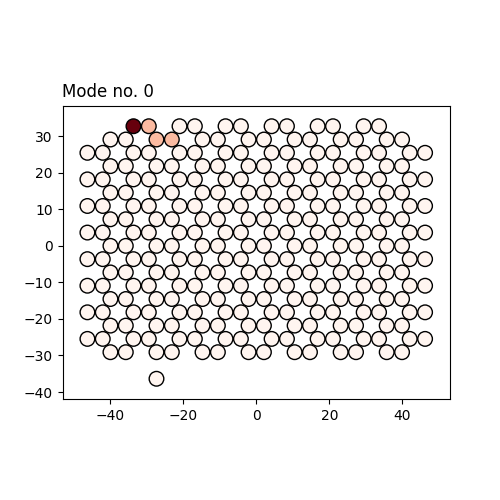

<ipython-input-20-bd8bd20360eb>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  intensity_to_plot[:,n] = intensities_at_distance


In [20]:
exciting_edge = np.zeros(len(beta_vals_1))
exciting_edge[135] = 1.0
exciting_edge[2] = 0.25
exciting_edge[139] = 0.25 
exciting_edge[6] = 0.25
plot_coloured_chain(exciting_edge, 4, deformed_lattice,0)
# print(beta_vecs_1[:,3]/np.sqrt(np.vdot(beta_vecs_1[:,3],beta_vecs_1[:,3])))
zrange = 0.05
zpoints = 500
intensity_to_plot = np.zeros((len(beta_vals_1), zpoints))
for n,i in enumerate(np.linspace(0,zrange, zpoints)):
    intensities_at_distance = calc_supermode(i, beta_vals_1, beta_vecs_1, 5876619, exciting_edge)#beta_vals_1, beta_vecs_1, 5876619, exciting_edge)
    intensity_to_plot[:,n] = intensities_at_distance

In [21]:
name_list = []
for i in range(np.shape(intensity_to_plot)[1]):
    fig_chain = plt.figure(figsize=(6,6))
    ax_chain = fig_chain.add_subplot(111)

    circ_list = []
    norm = colors.Normalize(vmin=0, vmax=np.max(np.real(intensity_to_plot[:,i])))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensity_to_plot)))
    for j in range(len(intensity_to_plot)):
        circ_list.append(patches.Circle((deformed_lattice[j][0], deformed_lattice[j][1]), radius=4//2,
                                            color=cmap(norm(np.real(intensity_to_plot[j,i]))),ec='black')) 

    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)

    plt.axis('scaled')

    plot_name = r'C:/Users/nr421/Documents/Twisted gifs/individual images/twisted propagation plot {:.1f}.png'.format(i)
    name_list.append(plot_name)
    fig_chain.savefig(plot_name)
    plt.close()
# name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
with imageio.get_writer('C:/Users/nr421/Documents/Twisted gifs/no zigzag edge 5cm excitation.gif', mode='I', duration=0.1, loop=0) as writer:
    for filename in name_list:
        image = imageio.imread(filename)
        writer.append_data(image)
writer.close()


TypeError: get_writer() missing 1 required positional argument: 'uri'

In [ ]:
two_coupled_core_vals, two_coupled_core_vecs = np.linalg.eigh(np.array([[0,50],[50,0]]))
excite_one = np.array([0,1])
plot_coloured_chain(excite_one, 4, np.array([[-2,0],[2,0]]),0)
# for i in np.linspace(0,0.02,10):
#     both_excited= calc_supermode(i, two_coupled_core_vals, two_coupled_core_vecs, 0, excite_one)
#     plot_coloured_chain(both_excited, 4, np.array([[-2,0],[2,0]]),0 )
#     print(both_excited)

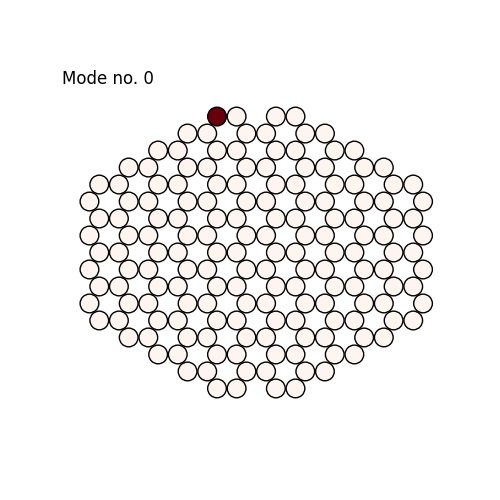

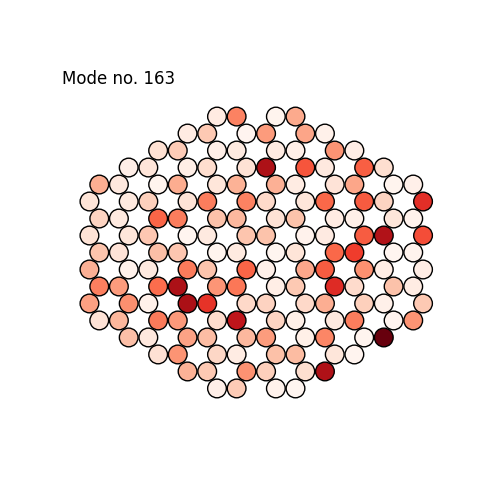

In [57]:
plot_coloured_chain(exciting_edge, 4, deformed_lattice,0)

plot_coloured_chain(intensities_at_distance, 4, deformed_lattice,i)



In [38]:
def plot_coloured_chain_gif(intensities, circ_size, circ_locations, save_as):
    """
    """
    name_list = []
    for i in range(np.shape(intensities)[1]):
        fig_chain = plt.figure(figsize=(12,10))
        ax_chain = fig_chain.add_subplot(111)

        circ_list = []
        norm = colors.Normalize(vmin=min(np.real(intensities[:,i])), vmax=max(np.real(intensities[:,i])))
        cmap = plt.cm.get_cmap('Greys_r').reversed()
        cmap(norm(np.real(intensities[:,i])))

        for j in range(len(intensities)):
            circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                                color=cmap(np.real(intensities[j,i])),ec='black')) 

        plt.axis('off')
        # Plot all circles
        for _circ in circ_list:
            ax_chain.add_patch(_circ)

        plt.axis('scaled')

        plot_name = 'winding_numbers/numerical_propagation/comsol_gif/SSH chain intensities step {:.2f}.png'.format(i)
        name_list.append(plot_name)
        fig_chain.savefig(plot_name)
        plt.close()
    name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
    with imageio.get_writer('winding_numbers/numerical_propagation/comsol_gif/'+save_as+'.gif', mode='I') as writer:
        for filename in name_list:
            image = imageio.imread(filename)
            writer.append_data(image)
    return 

In [ ]:
def plot_propagation_as_gif(z_list, evals, evecs, input_vec, circle_locations, file_out_name):
    
    mode_intensities = np.zeros([len(evals),len(z_list)],dtype=complex)
    for j,z in enumerate(z_list):
        mode_intensities[:,j] = propagator(z, evals, evecs, input_vec)
    
    

    #plot_coloured_chain_gif(mode_intensities,3,circle_locations,file_out_name)
    
    return mode_intensities

In [6]:
test_rand_vals, test_rand_vecs = np.linalg.eig(np.random.rand(4,4))
print(test_rand_vecs)
input_vec = np.array([1,0,0,0])

normalised_eigenvectors = test_rand_vecs / np.sqrt(np.einsum('i...,i...->...', np.conjugate(test_rand_vecs), test_rand_vecs))
normalised_eigenvectors = normalised_eigenvectors*np.exp(1.0j*test_rand_vals*1.0)
print(normalised_eigenvectors)
b_vec = np.einsum('i...,i...->...',  np.conjugate(normalised_eigenvectors), input_vec)
print(b_vec)

psi_mat = b_vec * normalised_eigenvectors * np.exp(1.0j * test_rand_vals * 1.0)

[[-0.42935281 -0.72928059  0.22843901 -0.14160749]
 [-0.54595815  0.14104012  0.11495483 -0.4036068 ]
 [-0.59689559  0.61392998  0.55206631 -0.41535749]
 [-0.40162361  0.26710949 -0.79361439  0.80282441]]
[[ 0.31621805-0.29043068j -0.68639073-0.24641012j  0.20568385-0.09939081j
  -0.13825011+0.03065269j]
 [ 0.4020978 -0.36930699j  0.13274538+0.04765479j  0.103504  -0.05001533j
  -0.39403767+0.08736567j]
 [ 0.43961319-0.40376303j  0.57782403+0.20743533j  0.49707415-0.2401968j
  -0.40550976+0.08990925j]
 [ 0.29579551-0.27167358j  0.25140046+0.09025124j -0.71456125+0.3452912j
   0.78379022-0.17378125j]]
[ 0.31621805+0.29043068j -0.68639073+0.24641012j  0.20568385+0.09939081j
 -0.13825011-0.03065269j]


In [9]:
print(np.array([[0,0],[1,1]]))
print(np.array([[0,0],[1,1]])* np.array([1,2]))

[[0 0]
 [1 1]]
[[0 0]
 [1 2]]
